# Crowd-YOLO (CYOLO)
- Step 0: Prepare necessary environment
- Step 1: Prepare data
- Step 2: Run experiments
- Step 3: Plot results
- Step 4: Plot additional annotations
- Plot custom annotation

### Step 0: Prepare necessary environment
- Ensure that there exists "master" data:
  - Images (`<data_directory>/images/<image_name>.jpg`)
  - Labels (`<data_directory>/labels/<volunteer_name>/<image_name>.txt`)
    - Experts would give ground-truth labels
    - Non-experts would give crowdsourced labels
- From the master data, we prepare multiple datasets for multiple experiments based on the following modes:
  - Size (**sz**) modes: toy (**to**), full (**fu**)
    - When in the toy mode, we only use a small sample of images (and their annotations). This is done mainly to check that our code works well. It's only a unit-test for our code. But the main experiment would be conducted on the full data (in the full (**fu**) mode).
  - Multiplicity (**ml**) modes: single (**si**), all (**all**)
    - To use labels from a single (**si**) labeller or multiple (**all**) labellers.
  - Train-Validation-Test modes:
    - Train (**tr**), Validation (**va**), Test (**te**)
      - What data to be used for training, validation, and testing of the model learnt.
    - Experts (**e**), Non-experts (**ne**)
      - Since labellers could either be experts or non-experts, we need to decide whether we want to use labels from experts or from non-experts. See below for examples.
    - Repeated (**r**), Crowdsourced (**c**)
      - If an algorithm that accepts training data in the usual form (i.e., one set of labels per image), we resolve "multiple" labellers' labels by repeating the (image, labels) combination as many number of times as there are labellers. More clearly, if we have a dataset as follows:
        - $(x_1, (y_{11}, y_{12}, \cdots, y_{1k_1}))$
        - $(x_2, (y_{21}, y_{22}, \cdots, y_{2k_2}))$
        - $\vdots$
        - $(x_n, (y_{n1}, y_{n2}, \cdots, y_{nk_n}))$,
      
        having $n$ images, with the $i^\text{th}$ image $x_i$ having labelled by $k_i$ labellers giving labels $y_{i1}, y_{i2}, \cdots, y_{ik_i}$. To use YOLO, a usual object detection algorithm, we transform this data via the "repeated" (**r**) mode into $\sum_{i=1}^{n}{k_i}$ (data, label) combinations:
        - $(x_1, y_{11})$
        - $(x_1, y_{12})$
        - $\cdots$
        - $(x_1, y_{1k_1})$,
        - $(x_2, y_{21})$
        - $(x_2, y_{22})$
        - $\cdots$
        - $(x_2, y_{2k_2})$,
        - $\vdots$
        - $(x_n, y_{n1})$
        - $(x_n, y_{n2})$
        - $\cdots$
        - $(x_n, y_{nk_n})$.
        
      - To be able to make use of the crowdsourced labels fully, we use Crowd-YOLO, and this is when we go with the "crowdsourced" (**c**) mode.
- For example, when running YOLO (without BCC), we have the following mode settings:
  - Size mode: full (**sz=fu**)
  - Multiplicity mode: multiple (**ml=all**)
  - Train-Validation-Test mode:
    - Train on non-expert repeated (iid) data: **tr=ner**
    - Validation on non-expert repeated (iid) data: **va=ner**
    - Test on expert repeated (iid) data: **te=er**
- But when running CYOLO (i.e., Crowd-YOLO), we have the following mode settings:
  - Size mode: full (**sz=fu**)
  - Multiplicity mode: multiple (**ml=all**)
  - Train-Validation-Test mode:
    - Train on non-expert crowdsourced data: **tr=nec**
    - Validation on non-expert repeated (iid) data: **va=ner**
    - Test on expert repeated (iid) data: **te=er**
- The modes that we use:
  - `singletoy-yolo`: **sz_to.ml_si.tr_ner.va_ner.te_er** --> For a quick run on the toy data using labels from a single volunteer for YOLO.
  - `singlefull-yolo`: **sz_fu.ml_si.tr_ner.va_ner.te_er** --> For the full data using labels from a single volunteer for YOLO.
  - `alltoy-yolo`: **sz_to.ml_all.tr_ner.va_ner.te_er** --> For a quick run on the toy data using all volunteers' labels for YOLO.
  - `allfull-yolo`: **sz_fu.ml_all.tr_ner.va_ner.te_er** --> For the full data using all volunteers' labels for YOLO.
  - `singletoy-cyolo`: **sz_to.ml_si.tr_nec.va_ner.te_er** --> For a quick run on the toy data using labels from a single volunteer for CYOLO.
  - `singlefull-cyolo`: **sz_fu.ml_si.tr_nec.va_ner.te_er** --> For the full data using labels from a single volunteer for CYOLO.
  - `multipletoy-cyolo`: **sz_to.ml_all.tr_nec.va_ner.te_er** --> For a quick run on the toy data using all volunteers' labels for CYOLO.
  - `multiplefull-cyolo`: **sz_fu.ml_all.tr_nec.va_ner.te_er** --> For the full data using all volunteers' labels for CYOLO.

### Step 1: Prepare data

In [1]:
import os
import sys
import json
import yaml
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatch
import matplotlib
%matplotlib inline
sys.path.append('../src/cyolo_utils')
from results_plotter import read_exp_results as read_exp

In [2]:
PROJ_PATH = '..'
sys.path.append(PROJ_PATH)

In [3]:
from src.data_preparer import prepare_data

In [4]:
SRC_PATH = os.path.join(PROJ_PATH, 'src')
DATA_PATH = os.path.join(PROJ_PATH, 'data/datasets')

In [5]:
data_modes = ['sty', 'stcy']

In [6]:
train_ratios = (0.7, 0.2, 0.1)
data_path = DATA_PATH
for mode in data_modes:
    prepare_data(mode, train_ratios, data_path)

Exception: Path already exists. Not recreating data

### Step 2: Run experiments

In [7]:
data = '../data/bcc-tvt.yaml'
#data = '../data/cyolo.yaml'
batch_size = 20 # Change this to number of train images
epochs = 1
bcc_epoch = 0 # Involve BCC from epoch number "bcc_epoch". Set to -1 for no BCC. 0 for all BCC.
exp_num = 1000
name = f'exp{exp_num}'

In [9]:
!python $SRC_PATH/train.py --data $data \
                           --batch-size $batch_size \
                           --epochs $epochs \
                           --bcc_epoch $bcc_epoch \
                           --name $name \
                           --exist-ok
print('Done')

Done


### Step 3: Plot results

In [24]:
from IPython.display import Image
print("Confusion Matrix")
Image(filename=os.path.join(f'runs/train/exp{exp_num}', 'confusion_matrix_0.25.png')) 

Confusion Matrix


FileNotFoundError: [Errno 2] No such file or directory: 'runs/train/exp1000\\confusion_matrix_0.25.png'

Learning Curves


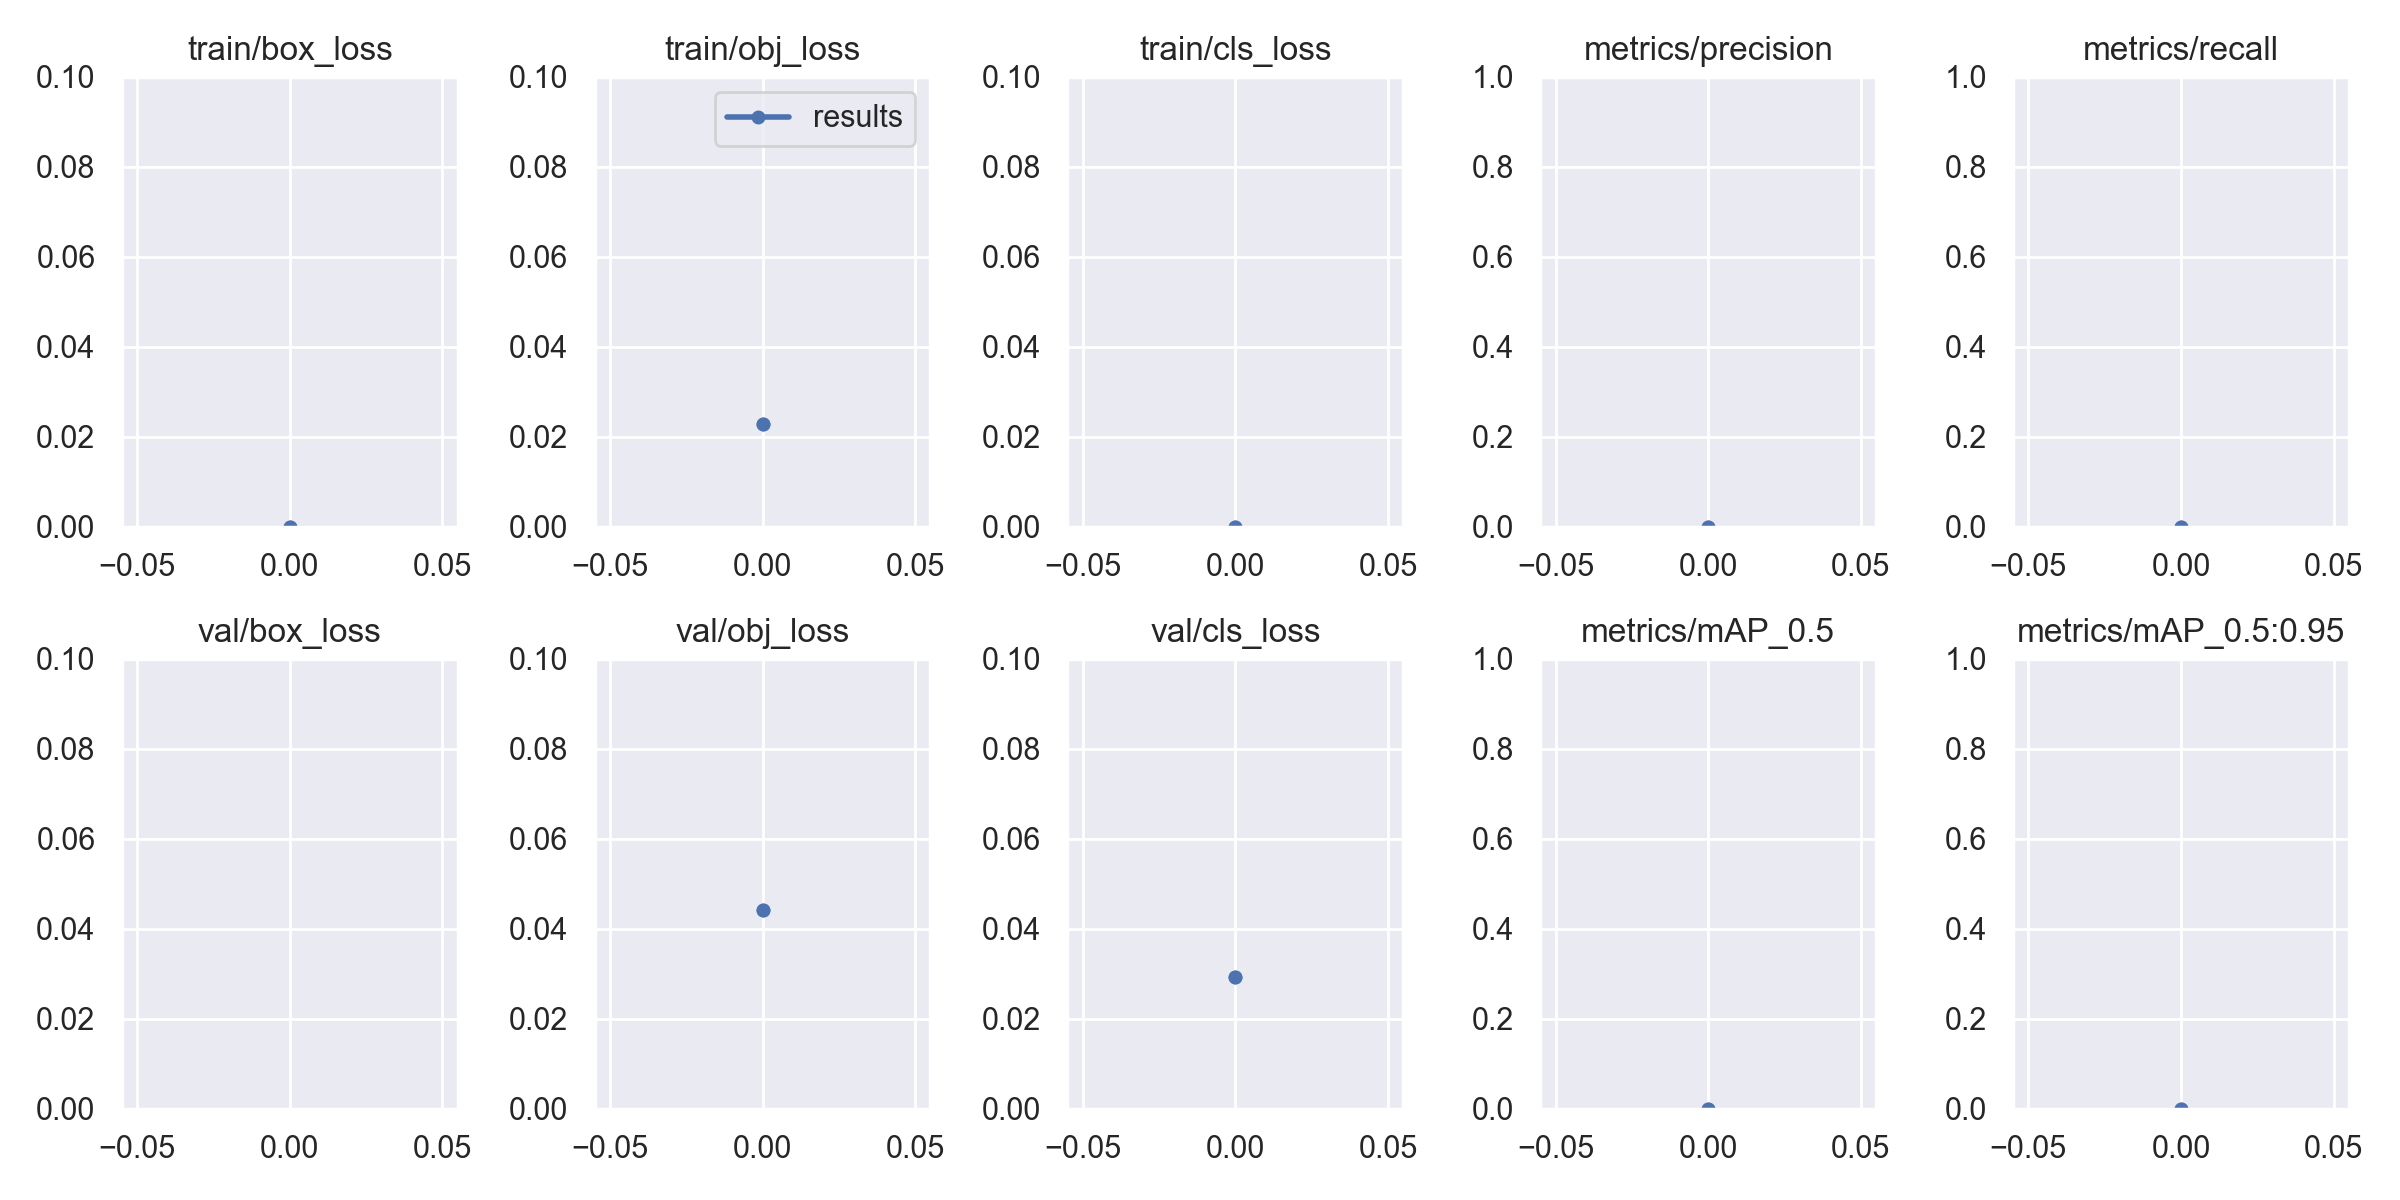

In [47]:
print("Learning Curves")
Image(filename=os.path.join(f'runs/train/exp{exp_num}', 'results.png')) 

Some predictions


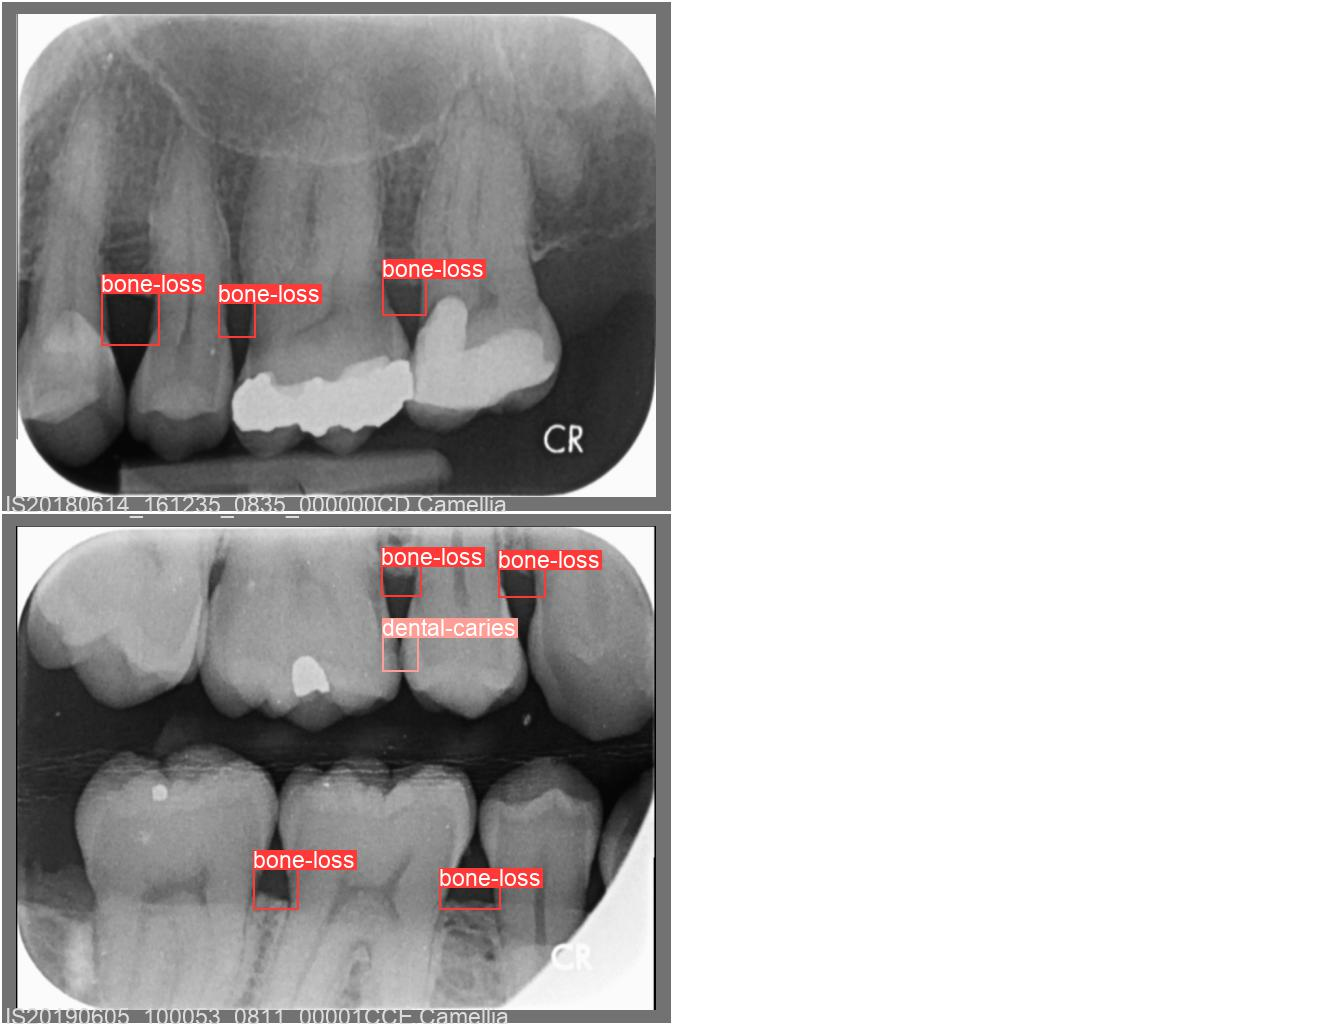

In [48]:
print("Some predictions")
Image(filename=os.path.join(f'runs/train/exp{exp_num}', 'val_batch0_labels.jpg')) 

### Step 4: Plot additional annotations

In [24]:
def get_im_vol_list(target_volunteers, num_images):
    im_vol_list = []
    for i in range(num_images):
        x = target_volunteers[target_volunteers[:,0] == i, -1].int().detach().numpy()
        num_boxes = x.shape[0]
        vol_per_im = []
        for j in range(num_boxes):
            vol_per_im.append(x[j])
        im_vol_list.append(vol_per_im)
    return im_vol_list

In [25]:
rel_path = os.path.join(os.curdir, 'runs', 'train')
# rel_path = os.path.join('/Users/gs0029/onedrive/University of Surrey/Yin, Camellia (PG R - Computer Science) - runs', 'train')

In [26]:
# metadata_filename = 'results_metadata.json'
# metadata = json.load(open(metadata_filename, 'r'))

metadata = {'baseline': {'name': 'yolo', 'exp_id': exp_num},
 'contribution': {'name': 'cyolo', 'exp_id': exp_num}}
metadata

{'baseline': {'name': 'yolo', 'exp_id': 100},
 'contribution': {'name': 'cyolo', 'exp_id': 100}}

In [27]:
exp_no = metadata['baseline']['exp_id']
exp_results = read_exp(exp_no, rel_path = rel_path)
exp_results.keys()

dict_keys(['results', 'hyp', 'opt', 'pred', 'cm'])

In [28]:
data_yaml_filename = exp_results['opt']['data']
data_dict = yaml.safe_load(open(data_yaml_filename, 'r'))
data_path = data_dict['path']
train_path = os.path.join(data_path, data_dict['train'])
val_path = os.path.join(data_path, data_dict['val'])
test_path = os.path.join(data_path, data_dict['test'])
data_dict

{'path': '../data/datasets',
 'train': 'single_toy_bcc-tvt/images/train',
 'val': 'single_toy_iid-tvt/images/val',
 'test': 'single_toy_iid-tvt/images/test',
 'nc': 2,
 'names': ['bone-loss', 'dental-caries']}

In [29]:
class_names = data_dict['names']
class_name_abbr_map = {'bone-loss': 'BL', 'dental-caries': 'DC'}

In [30]:
def get_im_boxes_map(preds):
    im_boxes_map = defaultdict(list)
    for pred in tqdm(preds):
        im_id = pred['image_id']
        im_boxes_map[im_id].append({k:v for k, v in pred.items() if k != 'image_id'})
    im_boxes_map = dict(im_boxes_map)
    im_names = list(sorted(im_boxes_map))
    return im_boxes_map, im_names

In [31]:
exp_no = metadata['baseline']['exp_id']
exp_results = read_exp(exp_no, rel_path = rel_path)
yolo_preds = exp_results['pred']
yolo_im_boxes_map, yolo_im_names = get_im_boxes_map(yolo_preds)

  0%|          | 0/600 [00:00<?, ?it/s]

In [32]:
exp_no = metadata['contribution']['exp_id']
exp_results = read_exp(exp_no, rel_path = rel_path)
cyolo_preds = exp_results['pred']
cyolo_im_boxes_map, cyolo_im_names = get_im_boxes_map(cyolo_preds)

  0%|          | 0/600 [00:00<?, ?it/s]

In [33]:
vol_names = ['Camellia', 'Conghui', 'HaoWen', 'Xiongjie']
vol_name_id_map = dict(zip(vol_names, range(1, 1+len(vol_names))))
im_prefs = list(sorted({x['image_id'].split('.')[0] for x in yolo_preds}))
vol_entries = []
for v in vol_names:
    labels_path = os.path.join(data_dict['path'], 'master', 'labels', v)
    for pref in im_prefs:
        label_file_path = os.path.join(labels_path, pref+'.txt')
        try:
            with open(label_file_path, 'r') as f:
                lines = [tuple(map(lambda x: round(float(x), 3), x.strip().split())) for x in f.readlines()]
            for c, x, y, w, h in lines:
                c = int(c)
                entry = {'image_id': pref,
                         'category_id': c,
                         'bbox': [x, y, w, h],
                         'volunteer': v}
                vol_entries.append(entry)
        except FileNotFoundError:
            print(label_file_path, 'not found')
            entry = {'image_id': pref,
                     'category_id': None,
                     'bbox': None,
                     'volunteer': v}
            vol_entries.append(entry)

vol_im_boxes_map, vol_im_names = get_im_boxes_map(vol_entries)

  0%|          | 0/27 [00:00<?, ?it/s]

In [34]:
exp_name = 'Jonathan'
im_prefs = list(sorted({x['image_id'].split('.')[0] for x in yolo_preds}))
exp_entries = []
labels_path = os.path.join(data_dict['path'], 'master', 'labels', exp_name)
for pref in im_prefs:
    label_file_path = os.path.join(labels_path, pref+'.txt')
    try:
        with open(label_file_path, 'r') as f:
            lines = [tuple(map(lambda x: round(float(x), 3), x.strip().split())) for x in f.readlines()]
        for c, x, y, w, h in lines:
            c = int(c)
            entry = {'image_id': pref,
                     'category_id': c,
                     'bbox': [x, y, w, h]}
            exp_entries.append(entry)
    except FileNotFoundError:
        print(label_file_path, 'not found')
        entry = {'image_id': pref,
                 'category_id': None,
                 'bbox': None}
        exp_entries.append(entry)
exp_im_boxes_map, exp_im_names = get_im_boxes_map(exp_entries)

  0%|          | 0/5 [00:00<?, ?it/s]

In [35]:
pref = list(exp_im_boxes_map)[0] # Or select your image of choice
boxes = exp_im_boxes_map[pref]
im_filepath = os.path.join(data_dict['path'], data_dict['val'], pref+'.Camellia.jpg')
img = mpimg.imread(im_filepath)
ht, wd, _ = img.shape

In [36]:
def get_im_boxes(im_name, mode):
    if mode == 'y':
        return yolo_im_boxes_map[im_name]
    elif mode == 'cy':
        return cyolo_im_boxes_map[im_name]
    elif mode == 'v':
        return vol_im_boxes_map[im_name.split('.')[0]]
    elif mode == 'e':
        return exp_im_boxes_map[im_name.split('.')[0]]

In [37]:
def plot_predboxes_per_radiograph(im_filepath, im_boxes, ax, conf_thres, mode):
    img = mpimg.imread(im_filepath)
    ht, wd, _ = img.shape

    ax.axis('off')
    img_plot = ax.imshow(img)

    box_linewidth = 2
    box_color_map = {'bone-loss': 'r', 'dental-caries': 'y'}
    use_abbr_labels = True
    text_on_box_color = 'w'
    text_on_box_fontsize = 10
    text_on_box_ha = 'left'
    text_on_box_va = 'center'

    for im_box in im_boxes:
        box_class = im_box['category_id']
        bbox = im_box['bbox']
        if box_class is None or bbox is None:
            print(im_filepath, 'has not been tagged by volunteer', im_box['volunteer'], '. Ignoring...')
            continue
        score_mode = True
        vol_mode = False
        try:
            box_score = im_box['score']
        except KeyError:
            score_mode = False
        try:
            vol_name = im_box['volunteer']
            vol_id = vol_name_id_map[vol_name]
            vol_mode = True
        except KeyError:
            pass
        text_on_box = class_names[box_class]
        if score_mode:
            if box_score < conf_thres[text_on_box]:
                continue
        box_color = box_color_map[text_on_box]
        if use_abbr_labels:
            text_on_box = class_name_abbr_map[text_on_box]
        if score_mode:
            text_on_box = f'{text_on_box} ({int(box_score*100)}%)'
        if vol_mode:
            text_on_box = f'{text_on_box} (V{vol_id})'
        x, y, w, h = bbox
        if mode in {'v', 'e'}:
            x, y, w, h = x*wd, y*ht, w*wd, h*ht
            px, py, pw, ph = x-w/2, y-h/2, w, h
        else:
            px, py, pw, ph = x, y, w, h
        box = mpatch.Rectangle((px, py), pw, ph, linewidth=box_linewidth, edgecolor=box_color, facecolor='none')
        ax.add_artist(box)
        _ = ax.annotate(text_on_box, (px+w/2, py-2*text_on_box_fontsize),
                        backgroundcolor=box_color,
                        color=text_on_box_color, weight='bold', 
                        fontsize=text_on_box_fontsize,
                        ha=text_on_box_ha,
                        va=text_on_box_va)

In [38]:
# Change this to select the images you need in the plot. Note that there are no suffixes.
image_prefixes_to_plot = ['IS20180614_161235_0835_000000CD',
                          'IS20190605_100053_0811_00001CCE']

scale = 15

radiographs_toplot_list = []
modes = ['v', 'e', 'y', 'cy']
mode_names = {'v': 'Volunteers',
              'e': 'Expert',
              'y': 'YOLO',
              'cy': 'CYOLO'}
default_vol_name = 'Camellia'
try:
    im_ids = [yolo_im_names.index(f'{i}.{default_vol_name}') for i in image_prefixes_to_plot]
except ValueError:
    paths = [os.path.join(val_path, f'{i}.{default_vol_name}.jpg') for i in image_prefixes_to_plot]
    raise Exception(f"Some image wasn't found in the IID validation dataset for YOLO. Ensure all the following paths have images:\n" + '\n'.join(paths))
for mode in modes:
    list_per_mode = []
    for im_id in im_ids:
        im_name = yolo_im_names[im_id]
        im_filename = f'{im_name}.jpg'
        im_filepath = os.path.join(val_path, im_filename)
        im_boxes = get_im_boxes(im_name, mode)
        list_per_mode.append((im_filepath, im_boxes))
    radiographs_toplot_list.append(list_per_mode)

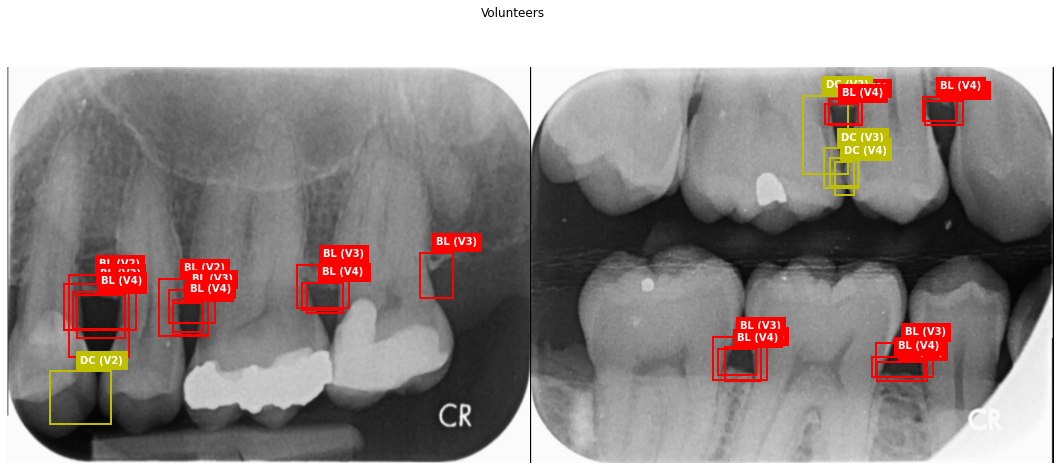

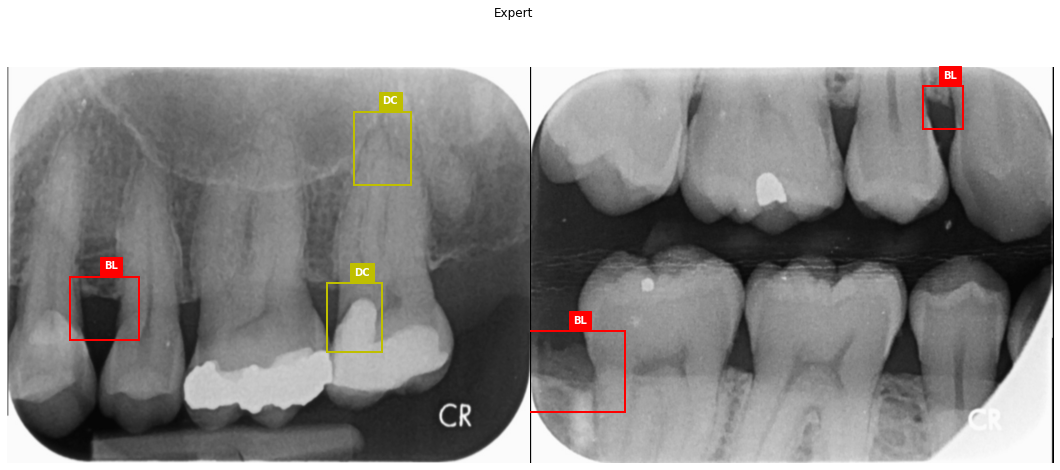

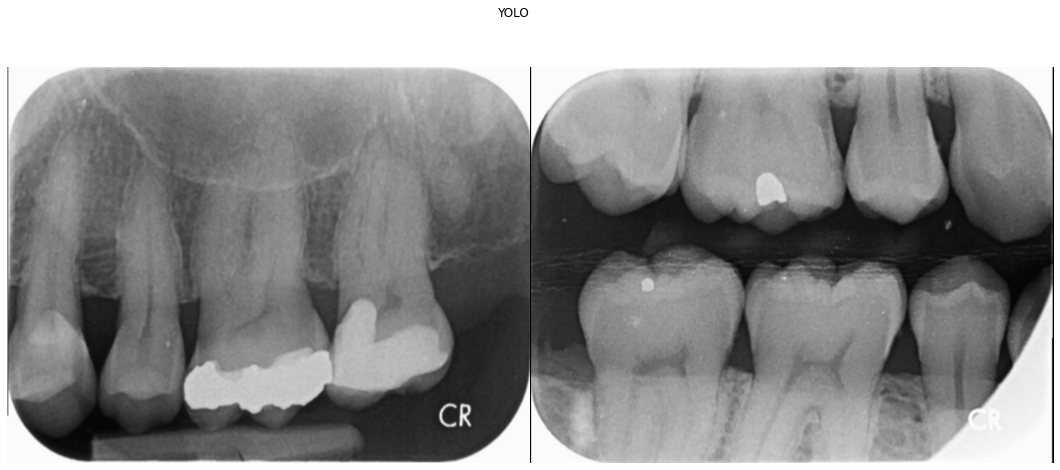

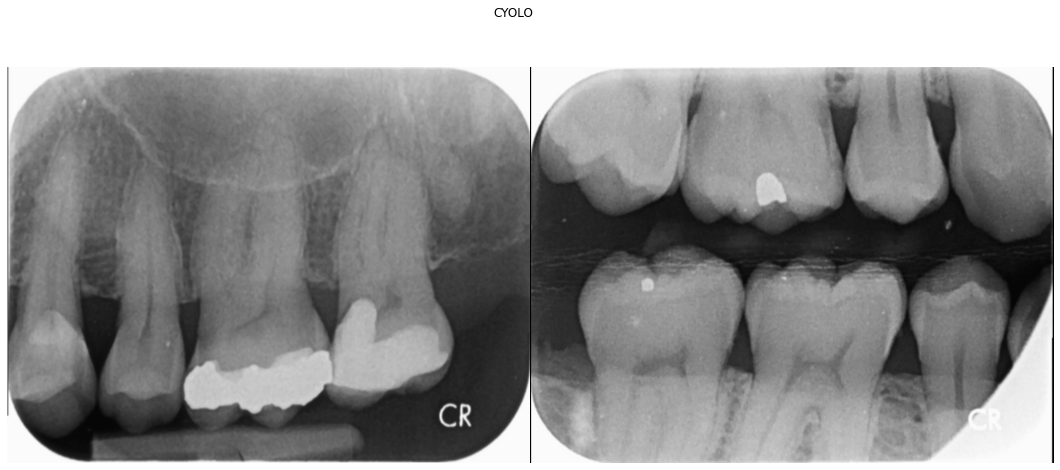

In [39]:
inner_grid = (1, 2)
conf_thres = {'bone-loss': 0.25, 'dental-caries': 0.05}

for m, mode in enumerate(modes):
    fig, axs = plt.subplots(*inner_grid, figsize=(1.25*scale, scale/2))
    # subfigs = fig.subfigures(*outer_grid)
    fig.suptitle(f'{mode_names[mode]}')
    fig.subplots_adjust(wspace=0, hspace=0)
    for innerind, ax in enumerate(axs.flat):
        im_filepath, im_boxes = radiographs_toplot_list[m][innerind]
        plot_predboxes_per_radiograph(im_filepath, im_boxes, ax, conf_thres, mode)

### Plot custom annotation

Unknown-X-20191113-111853-XYYUCGZJHAAT-3
1926 1487


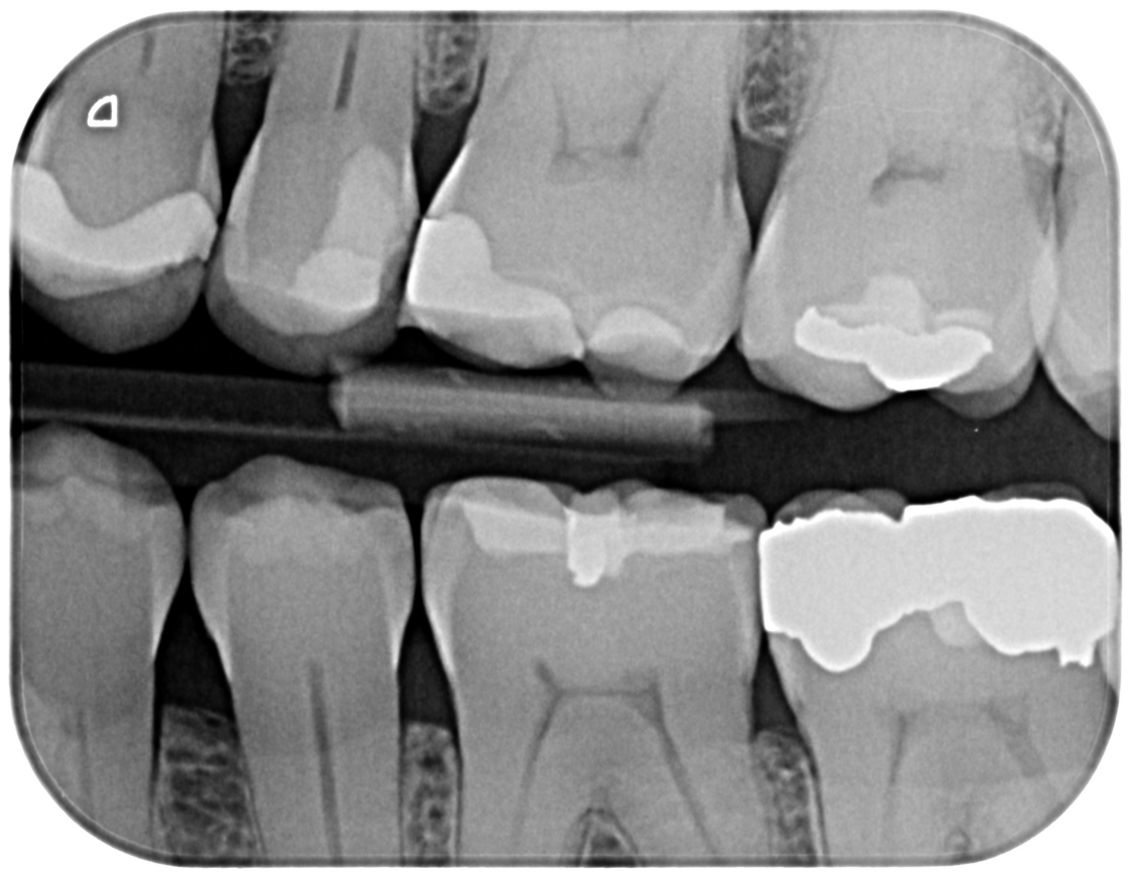

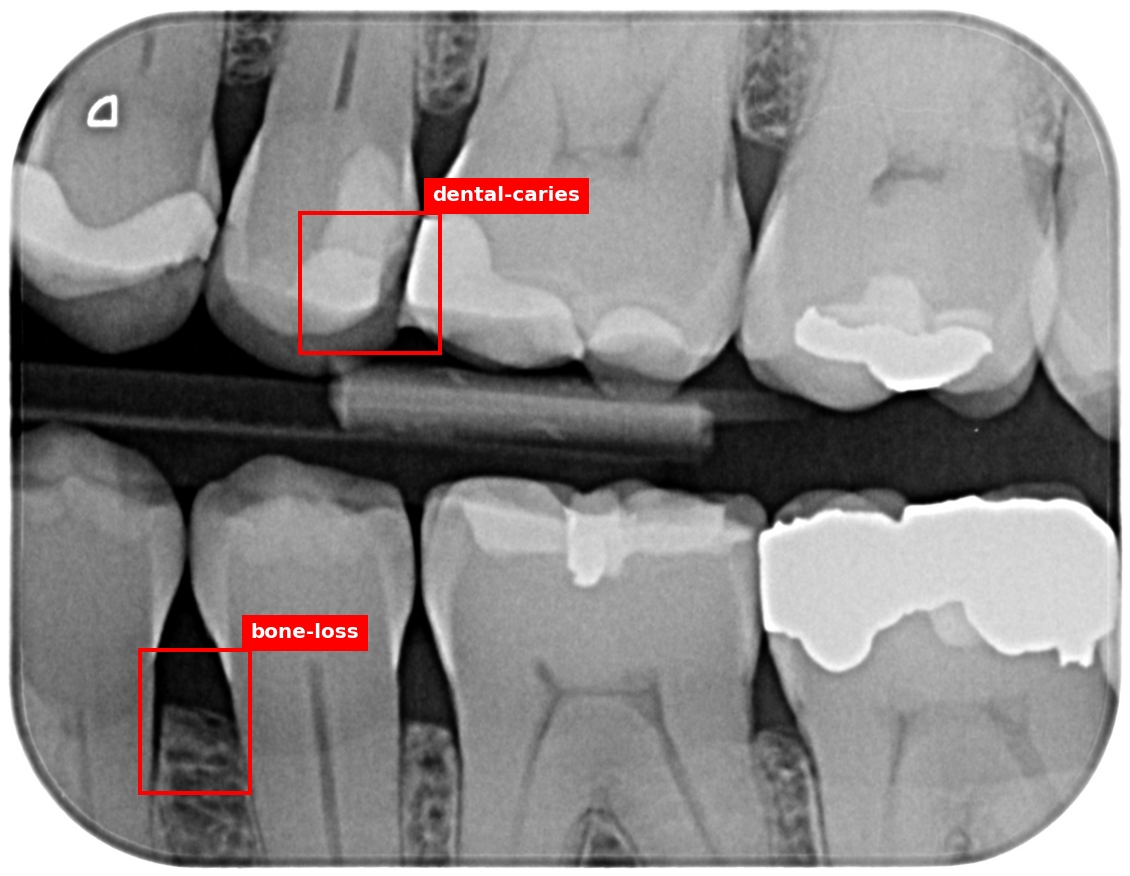

In [40]:
## Annotating a custom image

im_data_path = '../data/datasets/master/images/'
la_data_path = '../data/datasets/master/labels/Jonathan'
im_names = os.listdir(im_data_path)
im_prefs = [x.rsplit('.', 1)[0] for x in im_names]
for i in [10]:
    im_pref = im_prefs[i]
    print(im_pref)

    im_filepath = os.path.join(im_data_path, im_pref+'.jpg')
    img = mpimg.imread(im_filepath)
    ht, wd, _ = img.shape
    print(wd, ht)

    fig, ax = plt.subplots(figsize=(20,20))
    ax.axis('off')
    img_plot = ax.imshow(img)
    
    fig, ax = plt.subplots(figsize=(20,20))
    ax.axis('off')
    img_plot = ax.imshow(img)
    la_filepath = os.path.join(la_data_path, im_pref+'.txt')
    with open(la_filepath, 'r') as f:
        labels = [tuple(map(float, x.strip().split())) for x in f.readlines()]
    for label in labels:
        c = class_names[int(label[0])]
        x = label[1]*wd
        y = label[2]*ht
        w = label[3]*wd
        h = label[4]*ht
        c, x, y, w, h
        px, py, pw, ph = x-w/2, y-h/2, w, h
        box = mpatch.Rectangle((px, py), pw, ph, linewidth=4, edgecolor='r', facecolor='none')
        ax.add_artist(box)
        text_on_box = c
        _ = ax.annotate(text_on_box, (px+2*w, py-30),
                        backgroundcolor='r',
                        color='w', weight='bold', 
                        fontsize=20,
                        ha='right',
                        va='center')